## Apply Zhang and Uhlhorn 2012

CAVEAT: ZU12 yields the storm-relative inflow angle, but I should extract the earth-relative one to compare with SCAT or KXX. In my saved files, tangential_wind, radial_wind, and inflow_angle are given in Earth-relative, by convention.

In ZU12, Vmax and Vs are obtained from best-tracks.

In ZU12, for Rmax: "The Rmax value represents an average of individually observed wind maxima along each radial leg for a single flight." Thus I will take the Rmax_1D.

In ZU12, phase is defined clockwise from storm motion.

In SAR, in "cyclone_polar" files, phase is defined counter-clockwise from storm motion.

NB: To define Vs, I use IBTrACS, so the last three cases of the sample have nan values.

NB: We define the inflow angle as arctan(u / v) where we take v as positive even in the southern hemisphere, so that the inflow angle is always mostly negative.

In [1]:
# General
import glob
import re
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.optimize import minimize

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
# Paths & Params
PTHS = {
    'dsg_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/winddirection/PRJCT_TCBL/00_ZU12/',
}

PRMS = {
    'sav_fgs': False,
    'sav_css': False,
}

# Open data
dsg = xr.open_dataset(PTHS['dsg_pth'])

In [3]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 10) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20) &
    (dsg.dist2coast  > dsg.r34)              # Distance to coast
    # ((dsg.storm_speed_ibt / dsg.vws_pmd) > 1) # Ratio storm_speed / wind_shear
)
dsg_filtered    = dsg.where(cond, drop=True)
print(len(dsg_filtered.time))

472


In [4]:
# # Choose only southern hemisphere storms
# dsg_filtered = dsg_filtered.where(dsg_filtered.lat < 0, drop=True)
# print(len(dsg_filtered.time))

In [8]:
dsg_filtered = dsg_filtered.where(dsg_filtered.name == 'FRANKLIN', drop=True).isel(time=slice(1, None))

In [9]:
##############################
### Zhand and Uhlhorn 2012 ###
##############################
def inflow_angle(r_star, theta, vmax, vs):
    '''theta must be in radians.'''
    return Aa0(r_star, vmax) + Aa1_Aa0(r_star, vs) * Aa0(r_star, vmax) * np.cos(theta - np.deg2rad(Pa1(r_star, vs)))

def Aa0(r_star, vmax):
    '''output is in degrees.'''
    # aA0 = -0.90 
    aA0 = -0.90 - 0.2 # To match Fig. 12
    # bA0 = -0.90 
    bA0 = -0.11 # To match Fig. 12
    # cA0 = -14.33 
    cA0 = -12.8 # To match Fig. 12
    return aA0 * r_star + bA0 * vmax + cA0

def Aa1_Aa0(r_star, vs):
    aA1 = 0.04
    bA1 = 0.05
    # cA1 = 0.14
    cA1 = 0.09 # To match Fig. 13
    return -(aA1 * r_star + bA1 * vs + cA1)

def Pa1(r_star, vs):
    '''output is in degrees'''
    aP1 = 6.88
    bP1 = -9.60
    # cP1 = 85.31
    cP1 = 80 # To match Fig. 13
    return aP1 * r_star + bP1 * vs + cP1

#########################
### General functions ###
#########################

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

from scipy.interpolate import griddata

### Create ref. grid, choose resolution
dim_ref      = np.linspace(-500000, 500000, 1001)
x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)

def get_cartesian_var_from(Rs, THs, var):
    ds_x, ds_y = pol2cart(Rs, THs)
    var_car    = griddata((ds_x.flatten(), ds_y.flatten()), var.flatten(), (x_ref, y_ref), method='nearest')
    return var_car

In [10]:
def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return(mpl.colors.ListedColormap(colors, name="custom", N=nbCol))

def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

palette    = '/home/arthur/scripts/tools/high_wind_speed.pal'
cwnd       = getColorMap(rgbFile=palette)

In [11]:
subset = ['r_star', 'wind_speed', 'inflow_angle', 'radial_wind', 'tangential_wind']

for t in tqdm(range(len(dsg_filtered.time))):
    ### Open
    ds  = dsg_filtered.isel(time=t)
    # ds  = dsg_filtered.isel(time=40)
    # ds  = dsg_filtered.where((dsg_filtered.lat < 0) & (dsg_filtered.storm_speed_ibt > 8), drop=True).isel(time=0)
    dsp = xr.open_dataset(PTHS['sar_dir'] + ds.file_tcva.item()).isel(time=0)

    ### Apply ZU12
    vmx                 = float(ds.vmx_2d)
    rmx                 = float(ds.rmx)
    vs                  = float(ds.storm_speed_ibt)
    dsp['r_star']       = dsp['rad'].copy(deep=True) / rmx
    # Storm-relative
    dsp['inflow_angle_storm_relative'] = inflow_angle(dsp.r_star, -np.deg2rad(dsp.theta), vmx, vs) # "minus" sign to account for different definitions SAR vs ZU12!
    dsp['radial_wind_storm_relative']  = dsp.wind_speed * np.sin(np.deg2rad(dsp.inflow_angle_storm_relative))
    if ds.lat > 0:
        dsp['tangential_wind_storm_relative'] = dsp.wind_speed * np.cos(np.deg2rad(dsp.inflow_angle_storm_relative))
    else:
        dsp['tangential_wind_storm_relative'] = -dsp.wind_speed * np.cos(np.deg2rad(dsp.inflow_angle_storm_relative))
    # Earth-relative, adds the translation speed
    THs, _ = np.meshgrid(dsp.theta, dsp.rad)
    dsp['radial_wind']     = dsp['radial_wind_storm_relative']     + vs * np.cos(np.deg2rad(THs)) # Adds radial component of storm motion; NB, all images are oriented toward top of the page
    dsp['tangential_wind'] = dsp['tangential_wind_storm_relative'] - vs * np.sin(np.deg2rad(THs)) # Adds tangential component of storm motion
    dsp['inflow_angle']    = np.rad2deg(np.arctan(dsp.radial_wind / abs(dsp.tangential_wind)))    

    if PRMS['sav_fgs']:
        ### Prepare Plot
        # Convert to cartesian to plot
        dr, th       = np.meshgrid(dsp.rad, np.deg2rad(dsp.theta))
        ds_x, ds_y   = pol2cart(dr, th)
        # Create ref. grid, choose resolution
        dim_ref      = np.linspace(-500, 500, int((500 // 1 * 2) + 1)) * 1000
        x_ref, y_ref = np.meshgrid(dim_ref, dim_ref)
        # Interpolate on reference grid
        ws_car       = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.wind_speed.transpose()).flatten(),      (x_ref, y_ref), method='nearest')
        u_car        = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.radial_wind.transpose()).flatten(),     (x_ref, y_ref), method='nearest')
        v_car        = griddata((ds_x.flatten(), ds_y.flatten()), np.array(dsp.tangential_wind.transpose()).flatten(), (x_ref, y_ref), method='nearest')
        # Prepare the zonal and meridional components to add quiver
        alpha        = np.arctan2(y_ref, x_ref)
        U            = u_car * np.cos(alpha) - v_car * np.sin(alpha)
        V            = u_car * np.sin(alpha) + v_car * np.cos(alpha)

        ### Plot
        fig          = plt.figure(figsize=(10, 10))
        gs           = GridSpec(1, 1, hspace=0.1, wspace=0.01)
        cmap         = plt.get_cmap('PuOr') # Spectral
        normalizer   = Normalize(0, 80)
        ax_lims2D    = 400
        step         = 25
        
        #####################
        ### 2D WIND FIELD ###
        ts           = pd.to_datetime(str(ds.time.values)) 
        d            = ts.strftime('%Y-%m-%d %H:%M')
        
        # Texts
        ax           = fig.add_subplot(gs[0, 0])
        
        # SAR wind field
        im           = ax.pcolormesh(x_ref / 1000, y_ref / 1000, ws_car, cmap=cwnd, norm=normalizer)
        # ZU12 wind directions
        ax.quiver(x_ref[::step, ::step] / 1000, y_ref[::step, ::step] / 1000, U[::step, ::step], V[::step, ::step], color='k', scale=1500)
        
        # Axes
        ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
        ax.set_ylabel(r'Distance from TC center (km)')
        ax.set_xlabel(r'Distance from TC center (km)')
        ax.set_box_aspect(1)
        ax.minorticks_on()
        ax.tick_params(length=7, width=1.2)
        
        ax2 = ax.twinx().twiny() 
        ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
        ax2.minorticks_on()
        ax2.tick_params(axis='both', length=7, width=1.2)
        ax2.set_box_aspect(1)
        ax2.set_yticklabels([])
        ax2.set_xticklabels([])
        
        # Colorbar
        cb_ax = fig.add_axes([0.92, 0.113, 0.014, 0.767])
        cbar  = fig.colorbar(im, cax=cb_ax)
        cbar.set_label(r'Wind speed (m/s)', rotation=90)
        cbar.ax.get_yaxis().labelpad=5

        # Save
        plt.savefig(PTHS['sav_dir'] + 'figs/{}.png'.format(ds.file_tcva.item()[:-17]), bbox_inches='tight', format='png');plt.clf()

    if PRMS['sav_css']:
        # Save
        dsp[subset].to_netcdf(PTHS['sav_dir'] + 'cases/{}.nc'.format(ds.file_tcva.item()[:-17]))

  0%|          | 0/1 [00:00<?, ?it/s]

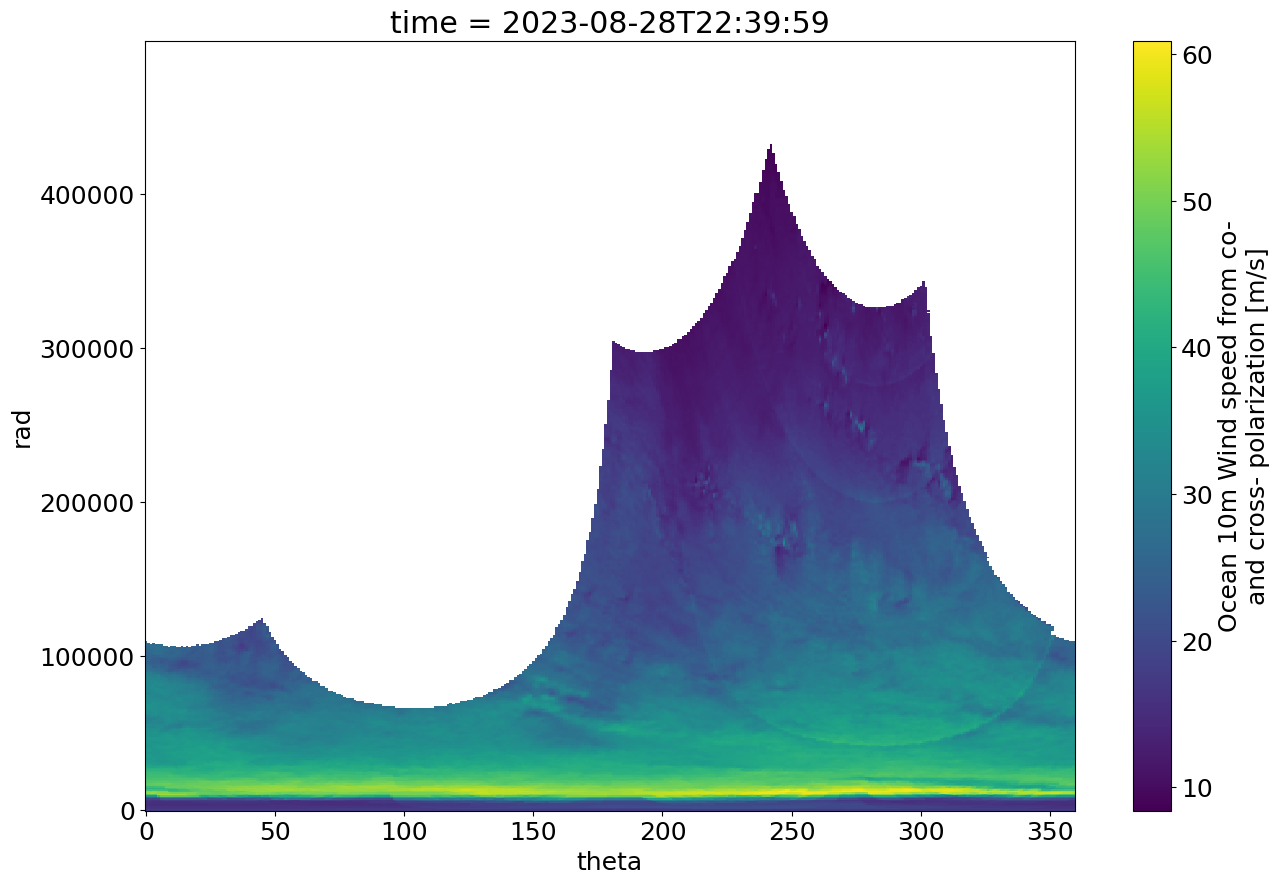

In [15]:
dsp.wind_speed.plot()

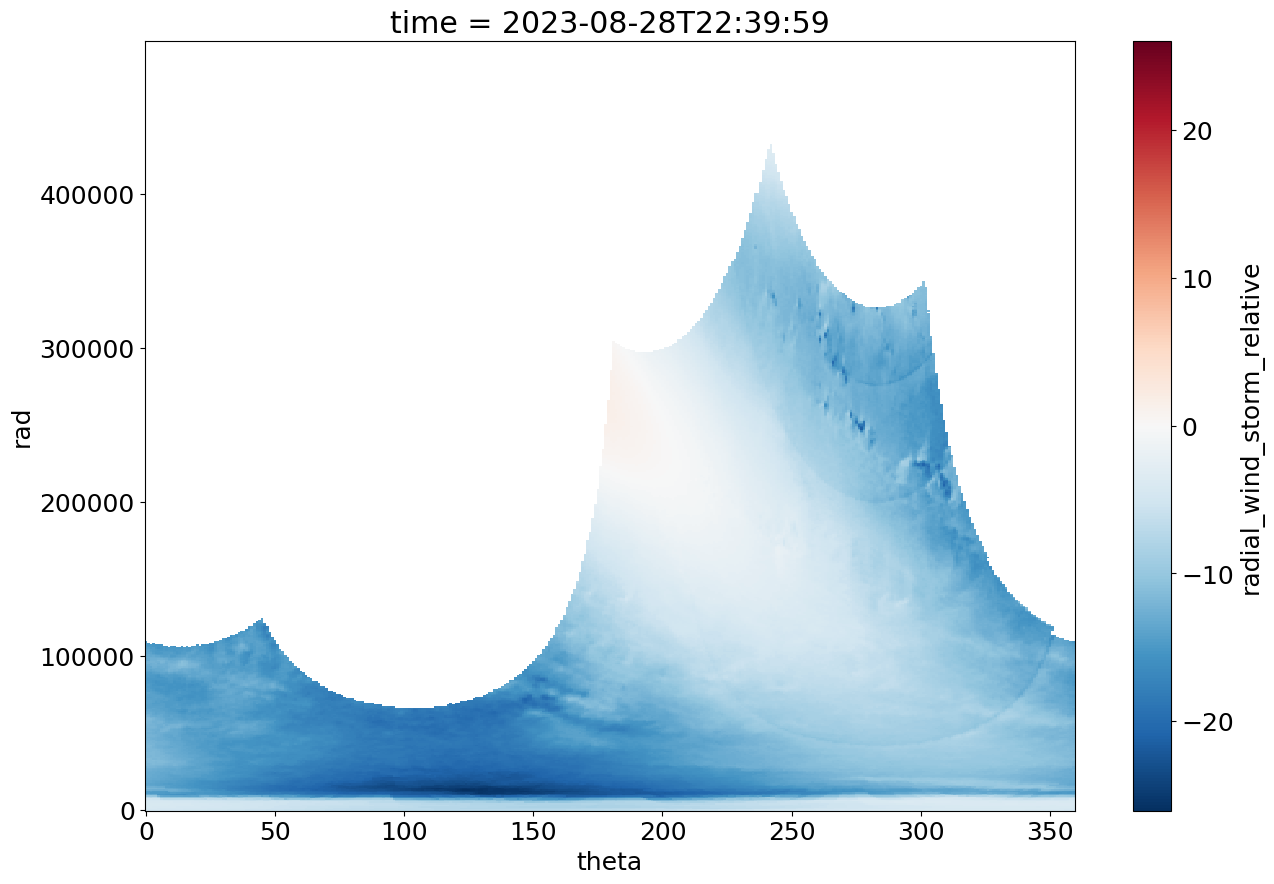

In [16]:
dsp.radial_wind_storm_relative.plot()